# Looking for signals of attention (and other mental states) in macaque V2

In [10]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import utils
import lvutils as lv
import mattplotlib as m
import modellib

def redo():
        reload(utils)
        reload(lv)
        reload(m)
        reload(modellib)

# Analysis on the bad data

In [8]:
baddata = utils.load_data('ki_0126_V2_py.mat')
# load the saved out latents
badmodel = utils.load_model('model1.pickle')
badR = utils.construct_R_matrix(baddata)
badZ = utils.construct_Z_matrix(badR, badmodel, num_latents=3)

../../data/hn/ ki_0126_V2_py.mat
Loaded ki_0126_V2_py.mat
190541 frames, 26 units, 870 trials with 192 frames each
  Time embedding...
  Time embedding...


## tried to do some projections of the latent variables, but with the bad data
```projections.ipynb```
<br />
<a href="http://localhost:4567/notebooks/lvs/projections.ipynb">[Notebook Link]</a>
<br />
<a href="https://github.com/NeuroTheoryUMD/mattjac/blob/main/lvs/projections.ipynb">[GitHub Link]</a>

<hr>

These projections are interesting, but not really useful for us.
Plus, at around trial 500, the electrodes show a large drift, 
and everything interestinf that follows is a result of that.

<Figure size 432x288 with 0 Axes>

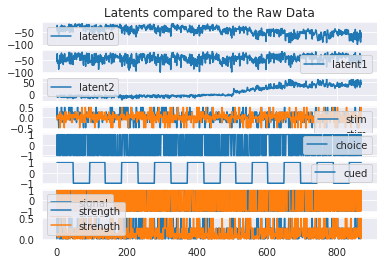

In [9]:
latent0 = np.mean(badZ, axis=1).T[0]
latent1 = np.mean(badZ, axis=1).T[1]
latent2 = np.mean(badZ, axis=1).T[2]
m.fig()
m.plots((latent0, "latent0"),
        (latent1, "latent1"),
        (latent2, "latent2"),
        (baddata.TRstim, "stim"),
        (baddata.TRchoice, "choice"),
        (baddata.TRcued, "cued"),
        (baddata.TRsignal, "signal"),
        (baddata.TRstrength, "strength"),
        title="Latents compared to the Raw Data")

## main analysis of the bad data
```baddata.ipynb```
<br />
<a href="http://localhost:4567/notebooks/lvs/baddata.ipynb">[Notebook Link]</a>
<br />
<a href="https://github.com/NeuroTheoryUMD/mattjac/blob/main/lvs/baddata.ipynb">[GitHub Link]</a>

<hr>

The latents averaged over time and trials are interesting.
However, the structure ("arms") we see 
is entirely due to electrode drift in this dataset.

/tmp/ipykernel_17988/1779649671.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


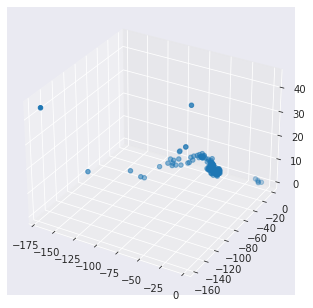

/tmp/ipykernel_17988/1779649671.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


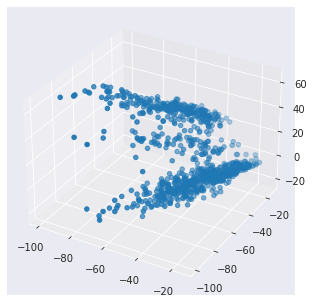

In [15]:
# plot the data averaged over time
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(np.mean(badZ, axis=0).T[0],
           np.mean(badZ, axis=0).T[1],
           np.mean(badZ, axis=0).T[2])
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(np.mean(badZ, axis=1).T[0],
           np.mean(badZ, axis=1).T[1],
           np.mean(badZ, axis=1).T[2])
plt.show()

## played with UMAP to find interesting relationships on the bad data
```umap.ipynb```
<br />
<a href="http://localhost:4567/notebooks/lvs/umap.ipynb">[Notebook Link]</a>
<br />
<a href="https://github.com/NeuroTheoryUMD/mattjac/blob/main/lvs/umap.ipynb">[GitHub Link]</a>

<hr>

UMAP is a very useful dimensionality reduction technique.
It is graph-based and, in this case, shows the same structure
that the autoencoder also shows
(the "arms" due to the drift at trial 500).

<Figure size 432x288 with 0 Axes>

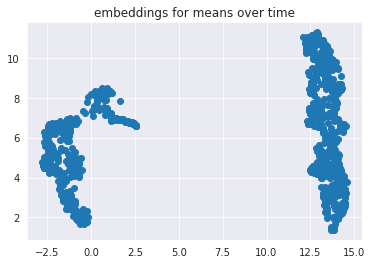

In [16]:
import umap
from sklearn.preprocessing import StandardScaler
import pandas as pd

# convert R to a pandas DataFrame
# collapse data along the time dimension (average across time)
means_across_time = pd.DataFrame(np.mean(badR, axis=1))
means_across_trials = pd.DataFrame(np.mean(badR, axis=0))

reducer = umap.UMAP()

neuron_embeddings = []

# fit the neurons over time and trials
for i in range(badR.shape[2]):
    scaled_R = StandardScaler().fit_transform(badR[:,:,i])
    neuron_embedding = reducer.fit_transform(scaled_R)
    neuron_embeddings.append(neuron_embedding)

scaled_means = StandardScaler().fit_transform(means_across_time)
time_embedding = reducer.fit_transform(scaled_means)
m.fig()
plt.scatter(
    time_embedding[:, 0],
    time_embedding[:, 1])
plt.title('embeddings for means over time')
plt.show()

## played with Spectral and HDBSCAN clustering to see if we can cluster the "arms" we see on the 3D plot, also on the bad data
```spectral.ipynb```
<br />
<a href="http://localhost:4567/notebooks/lvs/spectral.ipynb">[Notebook Link]</a>
<br />
<a href="https://github.com/NeuroTheoryUMD/mattjac/blob/main/lvs/spectral.ipynb">[GitHub Link]</a>

<hr>

Spectral clustering works OK, but HDBSCAN is a very good clustering algorithm.
Should definitely use this in the future for analyzing obvious
(or not so obvious) clustering in the data.

/tmp/ipykernel_17988/2931392101.py:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


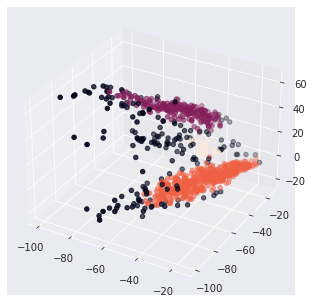

In [17]:
import hdbscan

trialbadZs = np.mean(badZ, axis=1)

labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=10,
).fit_predict(trialbadZs)

# plot the HDBSCAN calculated clusters (over trials) on the 3D plot (averaged over trials)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(np.mean(badZ, axis=1).T[0],
           np.mean(badZ, axis=1).T[1],
           np.mean(badZ, axis=1).T[2],
           c=labels)
plt.show()

## tried to add the drift term in, with the good data, but I didn't do it quite correctly
```drift.ipynb```
<br />
<a href="http://localhost:4567/notebooks/lvs/drift.ipynb">[Notebook Link]</a>
<br />
<a href="https://github.com/NeuroTheoryUMD/mattjac/blob/main/lvs/drift.ipynb">[GitHub Link]</a>

<hr>

The drift model was trained and was added into the model.
However, I don't know if it made a difference to the model fit.
This should be checked going forward by comparing 
the log-likelihood losses between model types.

Mean LL-null: 2.0058458


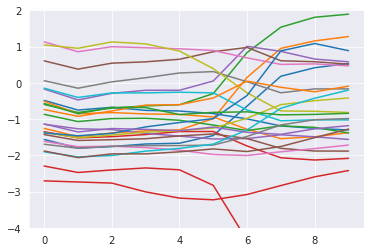

In [19]:
LLsNULL, drift_net, drift_mod = modellib.train_drift(baddata)
dw = drift_mod.get_weights()
plt.plot(dw)
plt.ylim([-4, 2])
plt.show()

# Analysis on the good data

## Some work to run the main LV analysis on the good data
```lvs.ipynb```
<br />
<a href="http://localhost:4567/notebooks/lvs/lvs.ipynb">[Notebook Link]</a>
<br />
<a href="https://github.com/NeuroTheoryUMD/mattjac/blob/main/lvs/lvs.ipynb">[GitHub Link]</a>

<hr>

Started to do some latent-variable analysis with the good data,
but need to do some more changes to the model before this can be further investigated. 